In [ ]:
# Installs all the necessary packages for the project
# %pip install pandas pandas-ta numpy matplotlib statsmodels pandas_datareader datetime yfinance scikit-learn PyPortfolioOpt
# %pip install --upgrade certifi

In [1]:
# Imports all the necessary packages for the project and fixes ssl error
import ssl
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta as ta
import warnings
warnings.filterwarnings('ignore')
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
# Get SP500 data    
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
symbols_list = sp500['Symbol'].unique().tolist()

end_date = dt.datetime.now().strftime('%Y-%m-%d')
start_date = (pd.to_datetime(end_date) - pd.DateOffset(years=10)).strftime('%Y-%m-%d')

df = yf.download(tickers=symbols_list, start=start_date, end=end_date).stack()

df.index.names = ['Date', 'Symbol']

df

[*********************100%%**********************]  503 of 503 completed


Adj Close       Close        High         Low        Open  \
Date       Symbol                                                               
2014-01-30 A        39.102077   42.567955   42.997139   41.788269   41.788269   
           AAL      31.864660   33.799999   34.200001   33.200001   33.360001   
           AAPL     15.648317   17.849285   18.089287   17.739286   17.947857   
           ABBV     32.019962   48.310001   48.880001   47.900002   47.970001   
           ABT      30.141998   36.529999   36.619999   36.139999   36.240002   
...                       ...         ...         ...         ...         ...   
2024-01-29 YUM     130.550003  130.550003  130.550003  128.289993  129.100006   
           ZBH     122.919998  122.919998  122.930000  120.940002  121.250000   
           ZBRA    255.929993  255.929993  256.040009  249.710007  250.720001   
           ZION     44.930000   44.930000   44.990002   43.770000   43.970001   
           ZTS     192.759995  192.759995  193.000000  189.960007  191.360001   

                        Volume  
Date       Symbol               
2014-01-30 A         5232994.0  
           AAL      13660500.0  
           AAPL    678501600.0  
           ABBV      7669500.0  
           ABT       9579800.0  
...                        ...  
2024-01-29 YUM       1482100.0  
           ZBH       1261100.0  
           ZBRA       493200.0  
           ZION      2051600.0  
           ZTS       1669900.0  

[1235380 rows x 6 columns]

In [3]:
# Calculate features and technical indicators
# Garman-Klass Volatility, RSI, Bollinger Bands, ATR, MACD, Dollar Volume,
# All but RSI are normalized by subtracting the mean and dividing by the standard deviation

df['Garman-Klass'] = ((np.log(df['High'])-np.log(df['Low']))**2)/2-(2*np.log(2)-1)*((np.log(df['Adj Close'])-np.log(df['Open']))**2)  

df['RSI'] = df.groupby(level=1)['Adj Close'].transform(lambda x: ta.rsi(close=x, length=20))

df['BB-Low'] = df.groupby(level=1)['Adj Close'].transform(lambda x: ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
df['BB-Mid'] = df.groupby(level=1)['Adj Close'].transform(lambda x: ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
df['BB-High'] = df.groupby(level=1)['Adj Close'].transform(lambda x: ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(data):
    atr = ta.atr(high=data['High'],
                        low=data['Low'],
                        close=data['Close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())
df['ATR'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['MACD'] = df.groupby(level=1, group_keys=False)['Adj Close'].apply(compute_macd)

df['Dollar Volume'] = (df['Adj Close']*df['Volume'])/1e6

df


Adj Close       Close        High         Low        Open  \
Date       Symbol                                                               
2014-01-30 A        39.102077   42.567955   42.997139   41.788269   41.788269   
           AAL      31.864660   33.799999   34.200001   33.200001   33.360001   
           AAPL     15.648317   17.849285   18.089287   17.739286   17.947857   
           ABBV     32.019962   48.310001   48.880001   47.900002   47.970001   
           ABT      30.141998   36.529999   36.619999   36.139999   36.240002   
...                       ...         ...         ...         ...         ...   
2024-01-29 YUM     130.550003  130.550003  130.550003  128.289993  129.100006   
           ZBH     122.919998  122.919998  122.930000  120.940002  121.250000   
           ZBRA    255.929993  255.929993  256.040009  249.710007  250.720001   
           ZION     44.930000   44.930000   44.990002   43.770000   43.970001   
           ZTS     192.759995  192.759995  193.000000  189.960007  191.360001   

                        Volume  Garman-Klass        RSI    BB-Low    BB-Mid  \
Date       Symbol                                                             
2014-01-30 A         5232994.0     -0.001299        NaN       NaN       NaN   
           AAL      13660500.0     -0.000372        NaN       NaN       NaN   
           AAPL    678501600.0     -0.007071        NaN       NaN       NaN   
           ABBV      7669500.0     -0.062912        NaN       NaN       NaN   
           ABT       9579800.0     -0.013026        NaN       NaN       NaN   
...                        ...           ...        ...       ...       ...   
2024-01-29 YUM       1482100.0      0.000104  54.522086  4.856006  4.872781   
           ZBH       1261100.0      0.000061  59.983131  4.794351  4.811772   
           ZBRA       493200.0      0.000150  53.441799  5.485959  5.542330   
           ZION      2051600.0      0.000198  60.239722  3.727839  3.786441   
           ZTS       1669900.0      0.000106  54.235582  5.230005  5.266838   

                    BB-High       ATR      MACD  Dollar Volume  
Date       Symbol                                               
2014-01-30 A            NaN       NaN       NaN     204.620937  
           AAL          NaN       NaN       NaN     435.287192  
           AAPL         NaN       NaN       NaN   10617.408350  
           ABBV         NaN       NaN       NaN     245.577101  
           ABT          NaN       NaN       NaN     288.754315  
...                     ...       ...       ...            ...  
2024-01-29 YUM     4.889556  0.213538  0.229472     193.488160  
           ZBH     4.829194 -0.529248  0.417161     155.014410  
           ZBRA    5.598702  0.264803  0.017950     126.224672  
           ZION    3.845044  0.643524  0.725046      92.178389  
           ZTS     5.303672  0.895050 -0.234498     321.889915  

[1235380 rows x 14 columns]

In [4]:
# Aggregate to monthly data and filter top 150 most liquid stocks for each month

tech_cols = [c for c in df.columns.unique(0) if c not in ['Dollar Volume', 'Volume', 'Open',
                                                          'High', 'Low', 'Close']]

tech_data = (pd.concat([df.unstack('Symbol')['Dollar Volume'].resample('M').mean().stack('Symbol').to_frame('Dollar Volume'),
                   df.unstack()[tech_cols].resample('M').last().stack('Symbol')],
                  axis=1)).dropna()

# Calculate 5-year rolling average of Dollar Volume
tech_data['Dollar Volume'] = (tech_data.loc[:, 'Dollar Volume'].unstack('Symbol').rolling(5*12, min_periods=12).mean().stack())

tech_data['DV Rank'] = (tech_data.groupby('Date')['Dollar Volume'].rank(ascending=False))

# Filter top 150 most liquid stocks for each month and put in new dataframe
#tech_data = tech_data[tech_data['DV Rank']<150].drop(['Dollar Volume', 'DV Rank'], axis=1)
top_150 = tech_data[tech_data['DV Rank'] < 150]

top_150


Dollar Volume   Adj Close  Garman-Klass        RSI  \
Date       Symbol                                                       
2015-02-28 AAL        489.261935   45.477360     -0.001642  45.417042   
           AAPL      5126.441709   28.860922     -0.005285  62.555839   
           ABBV       371.581309   41.377705     -0.055845  48.492238   
           ABT        195.715541   39.949802     -0.011462  61.637940   
           ACN        189.507276   77.266289     -0.009006  55.963560   
...                          ...         ...           ...        ...   
2024-01-31 VRTX       392.082837  435.820007      0.000081  67.108268   
           VZ         790.420782   42.049999      0.000150  67.765128   
           WFC        992.224655   50.349998      0.000086  63.793627   
           WMT        976.308700  165.039993      0.000059  62.147119   
           XOM       1414.942821  103.129997      0.000085  55.927607   

                     BB-Low    BB-Mid   BB-High       ATR      MACD  DV Rank  
Date       Symbol                                                             
2015-02-28 AAL     3.807215  3.858552  3.909890  1.977118 -0.192471     35.0  
           AAPL    3.289049  3.368803  3.448558 -0.778323  0.275885      1.0  
           ABBV    3.660831  3.721655  3.782480 -0.701264 -0.423143     51.0  
           ABT     3.641809  3.685499  3.729188 -0.908104  0.367983    116.0  
           ACN     4.306899  4.345959  4.385019 -0.966128 -0.041851    120.0  
...                     ...       ...       ...       ...       ...      ...  
2024-01-31 VRTX    6.010777  6.057808  6.104838  0.939327  2.610047    116.0  
           VZ      3.629096  3.703497  3.777898  0.160099  2.717067     45.0  
           WFC     3.861975  3.908648  3.955320 -0.394289  0.733839     33.0  
           WMT     5.059360  5.086992  5.114623  0.134637  1.149058     34.0  
           XOM     4.569273  4.614577  4.659881  0.194668 -0.172581     17.0  

[16092 rows x 10 columns]

In [5]:
# Calculate monthly returns for different time horizons on the top 150 most liquid stocks
def calculate_returns(df):
    outlier_cutoff = 0.005
    lags = [1, 2, 3, 6, 9, 12]
    for lag in lags:
        df[f'{lag}m Return'] = (df['Adj Close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df

returns = top_150.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()
returns

Dollar Volume   Adj Close  Garman-Klass        RSI  \
Date       Symbol                                                       
2016-02-29 AAL        479.985126   39.288372     -0.000319  54.607039   
           AAPL      5210.567818   22.125885     -0.003013  46.730961   
           ABBV       404.930433   38.690914     -0.051766  48.010326   
           ABT        216.240062   33.398449     -0.009964  46.271596   
           ACN        209.341640   87.900642     -0.006994  49.785687   
...                          ...         ...           ...        ...   
2024-01-31 VRTX       392.082837  435.820007      0.000081  67.108268   
           VZ         790.420782   42.049999      0.000150  67.765128   
           WFC        992.224655   50.349998      0.000086  63.793627   
           WMT        976.308700  165.039993      0.000059  62.147119   
           XOM       1414.942821  103.129997      0.000085  55.927607   

                     BB-Low    BB-Mid   BB-High       ATR      MACD  DV Rank  \
Date       Symbol                                                              
2016-02-29 AAL     3.547833  3.638645  3.729458  0.676767  0.537717     39.0   
           AAPL    3.106253  3.130723  3.155194 -0.830321 -0.352483      1.0   
           ABBV    3.629341  3.677365  3.725388 -0.333810 -0.284954     49.0   
           ABT     3.479070  3.522661  3.566251 -0.587075 -0.392073    113.0   
           ACN     4.405535  4.474354  4.543174 -0.606057 -0.297519    121.0   
...                     ...       ...       ...       ...       ...      ...   
2024-01-31 VRTX    6.010777  6.057808  6.104838  0.939327  2.610047    116.0   
           VZ      3.629096  3.703497  3.777898  0.160099  2.717067     45.0   
           WFC     3.861975  3.908648  3.955320 -0.394289  0.733839     33.0   
           WMT     5.059360  5.086992  5.114623  0.134637  1.149058     34.0   
           XOM     4.569273  4.614577  4.659881  0.194668 -0.172581     17.0   

                   1m Return  2m Return  3m Return  6m Return  9m Return  \
Date       Symbol                                                          
2016-02-29 AAL      0.054421  -0.014726  -0.001198   0.009277  -0.002847   
           AAPL    -0.001288  -0.038976  -0.063339  -0.023726  -0.031060   
           ABBV    -0.005282  -0.034844  -0.017302  -0.018800  -0.018854   
           ABT      0.023513  -0.068304  -0.046141  -0.023736  -0.023047   
           ACN     -0.050028  -0.020497  -0.022124   0.012121   0.005983   
...                      ...        ...        ...        ...        ...   
2024-01-31 VRTX     0.071100   0.108296   0.063707   0.036074   0.027726   
           VZ       0.120192   0.056197   0.063256   0.042198   0.015142   
           WFC      0.022958   0.062627   0.085008   0.017408   0.029407   
           WMT      0.046876   0.031500   0.004555   0.006546   0.011190   
           XOM      0.031506   0.001896  -0.005627  -0.003629  -0.012331   

                   12m Return  
Date       Symbol              
2016-02-29 AAL      -0.012116  
           AAPL     -0.021902  
           ABBV     -0.005579  
           ABT      -0.014815  
           ACN       0.010804  
...                       ...  
2024-01-31 VRTX      0.025253  
           VZ        0.006981  
           WFC       0.008573  
           WMT       0.012782  
           XOM      -0.006985  

[13801 rows x 16 columns]

In [6]:
# Use Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start=start_date, end=end_date)[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data.index.name = 'Date'
factor_data = factor_data.resample('M').last().div(100)
factor_data = factor_data.join(returns['1m Return']).sort_index()


# Filter out stocks with less than 10 months of data.
observations = factor_data.groupby(level=1).size()
valid_stocks = observations[observations >= 10]
factor_data = factor_data[factor_data.index.get_level_values('Symbol').isin(valid_stocks.index)]

factor_data


Mkt-RF     SMB     HML     RMW     CMA  1m Return
Date       Symbol                                                   
2016-02-29 AAL    -0.0007  0.0088 -0.0057  0.0325  0.0202   0.054421
           AAPL   -0.0007  0.0088 -0.0057  0.0325  0.0202  -0.001288
           ABBV   -0.0007  0.0088 -0.0057  0.0325  0.0202  -0.005282
           ABT    -0.0007  0.0088 -0.0057  0.0325  0.0202   0.023513
           ACN    -0.0007  0.0088 -0.0057  0.0325  0.0202  -0.050028
...                   ...     ...     ...     ...     ...        ...
2023-11-30 VRTX    0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.020160
           VZ      0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.091090
           WFC     0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.131192
           WMT     0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.047243
           XOM     0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.020506

[13474 rows x 6 columns]

In [7]:
# Calculate Rolling Factor Betas

betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['1m Return'], 
                                     exog=sm.add_constant(x.drop('1m Return', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

#betas 

# Join betas to returns dataframe
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
data = (returns.join(betas.groupby('Symbol').shift()))
data.loc[:, factors] = data.groupby('Symbol', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))
#data = data.drop(['Adj Close', 'Dollar Volume', 'DV Rank', axis=1)
data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 13545 entries, (Timestamp('2016-02-29 00:00:00'), 'AAL') to (Timestamp('2024-01-31 00:00:00'), 'XOM')
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Dollar Volume  13545 non-null  float64
 1   Adj Close      13545 non-null  float64
 2   Garman-Klass   13545 non-null  float64
 3   RSI            13545 non-null  float64
 4   BB-Low         13545 non-null  float64
 5   BB-Mid         13545 non-null  float64
 6   BB-High        13545 non-null  float64
 7   ATR            13545 non-null  float64
 8   MACD           13545 non-null  float64
 9   DV Rank        13545 non-null  float64
 10  1m Return      13545 non-null  float64
 11  2m Return      13545 non-null  float64
 12  3m Return      13545 non-null  float64
 13  6m Return      13545 non-null  float64
 14  9m Return      13545 non-null  float64
 15  12m Return     13545 non-null  float64
 16  Mkt-RF         135

In [8]:
# K-Means Clustering for each month
from sklearn.cluster import KMeans
# N Clusters = 4
# Define initial centroids
#initial_centroids = 

#data = data.drop('Cluster', axis=1)

def get_clusters(df):
    df['Cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init='random').fit(df).labels_
    return df

data = data.dropna().groupby('Date', group_keys=False).apply(get_clusters)

data


Dollar Volume   Adj Close  Garman-Klass        RSI  \
Date       Symbol                                                       
2016-02-29 AAL        479.985126   39.288372     -0.000319  54.607039   
           AAPL      5210.567818   22.125885     -0.003013  46.730961   
           ABBV       404.930433   38.690914     -0.051766  48.010326   
           ABT        216.240062   33.398449     -0.009964  46.271596   
           ACN        209.341640   87.900642     -0.006994  49.785687   
...                          ...         ...           ...        ...   
2024-01-31 VRTX       392.082837  435.820007      0.000081  67.108268   
           VZ         790.420782   42.049999      0.000150  67.765128   
           WFC        992.224655   50.349998      0.000086  63.793627   
           WMT        976.308700  165.039993      0.000059  62.147119   
           XOM       1414.942821  103.129997      0.000085  55.927607   

                     BB-Low    BB-Mid   BB-High       ATR      MACD  DV Rank  \
Date       Symbol                                                              
2016-02-29 AAL     3.547833  3.638645  3.729458  0.676767  0.537717     39.0   
           AAPL    3.106253  3.130723  3.155194 -0.830321 -0.352483      1.0   
           ABBV    3.629341  3.677365  3.725388 -0.333810 -0.284954     49.0   
           ABT     3.479070  3.522661  3.566251 -0.587075 -0.392073    113.0   
           ACN     4.405535  4.474354  4.543174 -0.606057 -0.297519    121.0   
...                     ...       ...       ...       ...       ...      ...   
2024-01-31 VRTX    6.010777  6.057808  6.104838  0.939327  2.610047    116.0   
           VZ      3.629096  3.703497  3.777898  0.160099  2.717067     45.0   
           WFC     3.861975  3.908648  3.955320 -0.394289  0.733839     33.0   
           WMT     5.059360  5.086992  5.114623  0.134637  1.149058     34.0   
           XOM     4.569273  4.614577  4.659881  0.194668 -0.172581     17.0   

                   ...  3m Return  6m Return  9m Return  12m Return    Mkt-RF  \
Date       Symbol  ...                                                          
2016-02-29 AAL     ...  -0.001198   0.009277  -0.002847   -0.012116  1.337369   
           AAPL    ...  -0.063339  -0.023726  -0.031060   -0.021902  1.060159   
           ABBV    ...  -0.017302  -0.018800  -0.018854   -0.005579  0.767189   
           ABT     ...  -0.046141  -0.023736  -0.023047   -0.014815  0.930795   
           ACN     ...  -0.022124   0.012121   0.005983    0.010804  1.147994   
...                ...        ...        ...        ...         ...       ...   
2024-01-31 VRTX    ...   0.063707   0.036074   0.027726    0.025253  0.841608   
           VZ      ...   0.063256   0.042198   0.015142    0.006981  0.615772   
           WFC     ...   0.085008   0.017408   0.029407    0.008573  1.218894   
           WMT     ...   0.004555   0.006546   0.011190    0.012782  0.789735   
           XOM     ...  -0.005627  -0.003629  -0.012331   -0.006985  1.137861   

                        SMB       HML       RMW       CMA  Cluster  
Date       Symbol                                                   
2016-02-29 AAL     1.046155  0.698202  0.776533  0.239404        0  
           AAPL   -0.182376 -0.517186  0.586005 -0.433642        2  
           ABBV    0.216802  0.091518 -0.213488 -0.099808        3  
           ABT    -0.197985 -0.539032  0.081867  0.751985        3  
           ACN    -0.145309 -0.259703  0.182515 -0.016458        3  
...                     ...       ...       ...       ...      ...  
2024-01-31 VRTX    0.053370 -1.337754 -0.081830  0.967235        1  
           VZ     -0.366403 -0.049590  0.358692  0.968046        1  
           WFC    -0.145993  1.262533 -0.675744 -0.184589        1  
           WMT    -0.513188 -0.205649  0.602155  0.641779        1  
           XOM     0.277134  0.339980 -0.447416  0.912330        3  

[13545 rows x 22 columns]

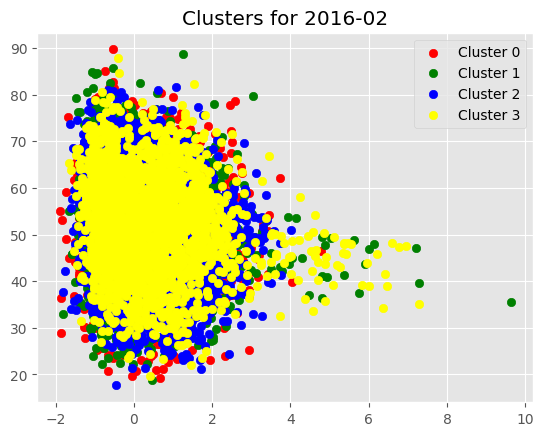

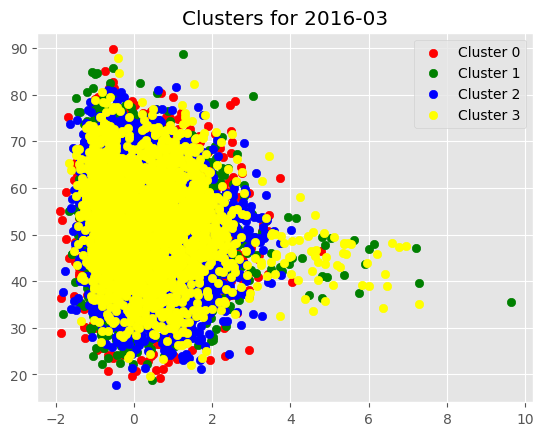

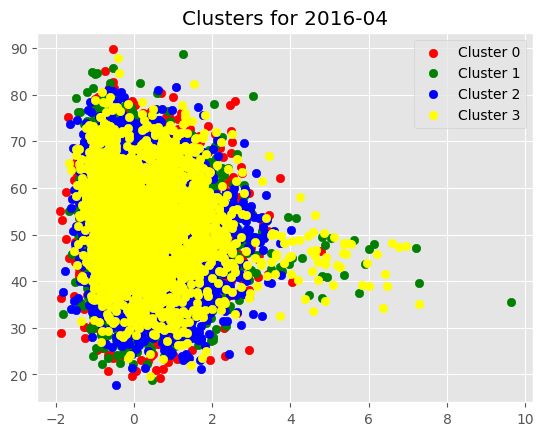

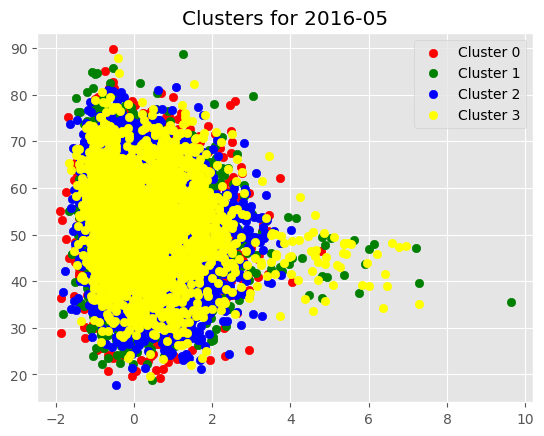

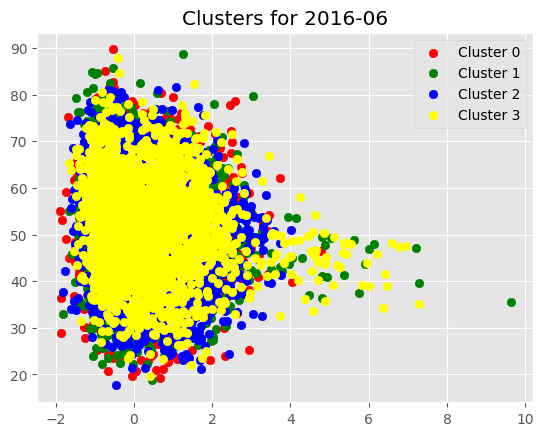

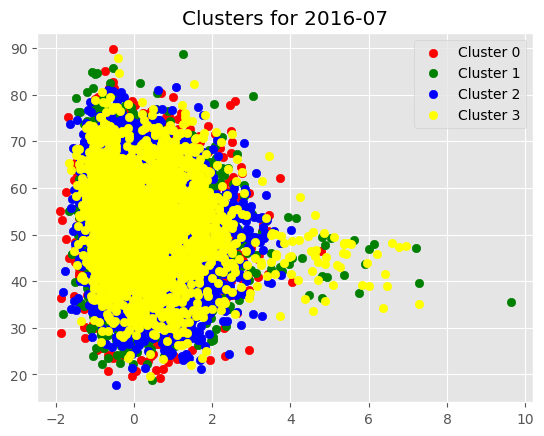

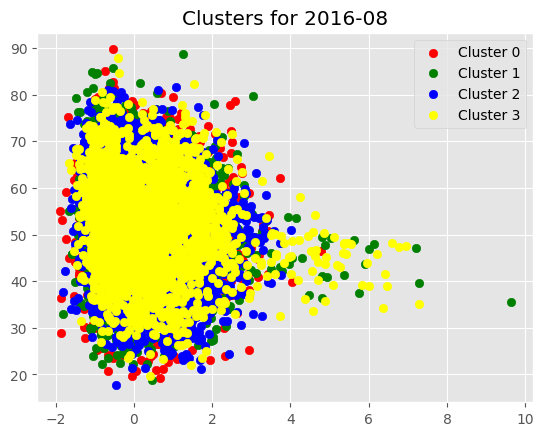

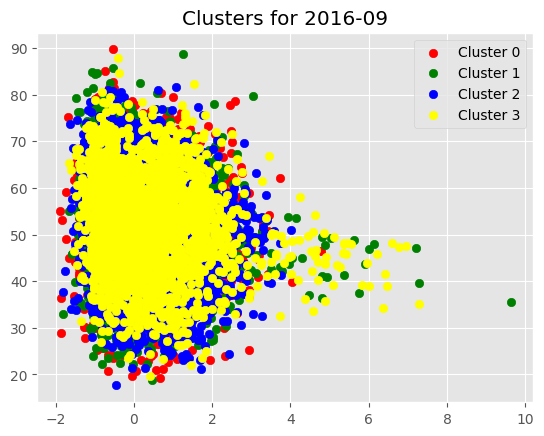

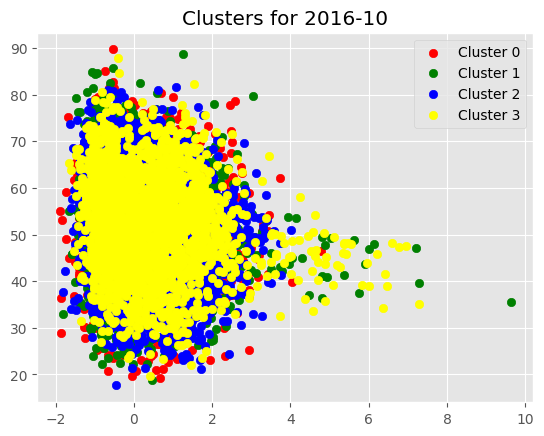

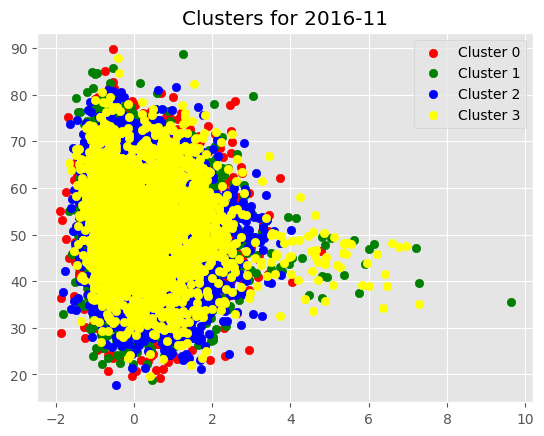

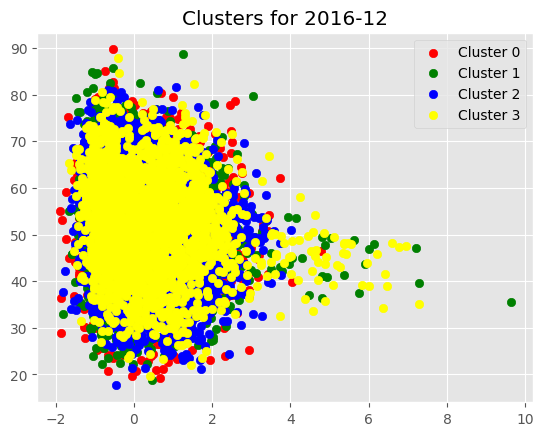

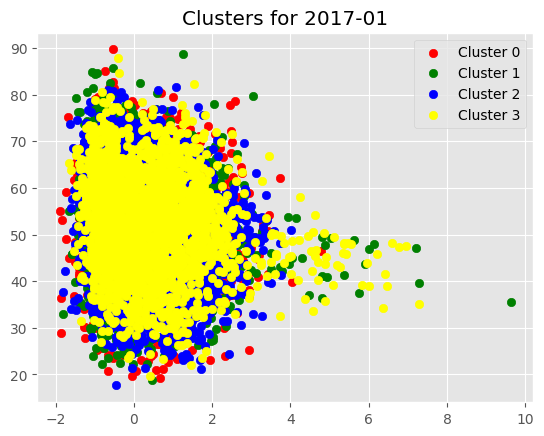

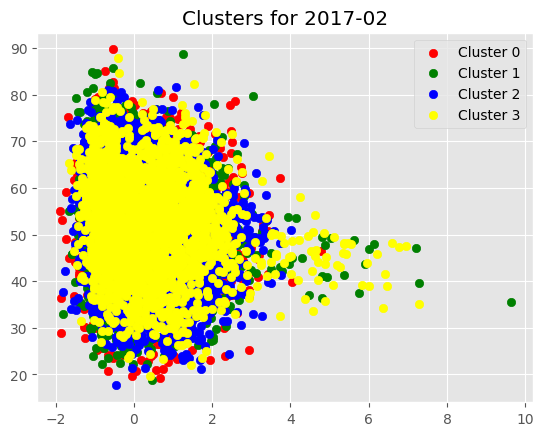

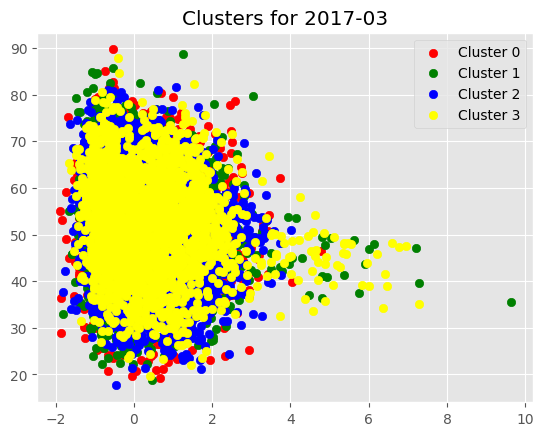

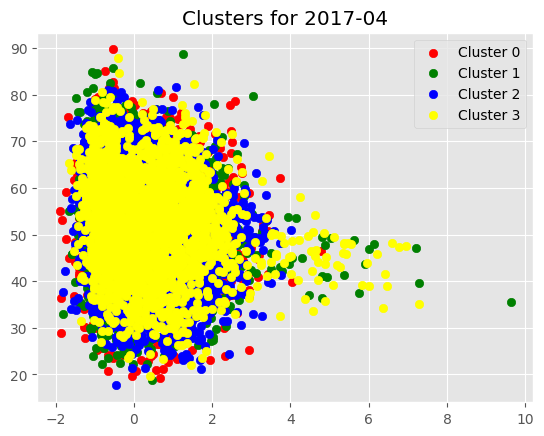

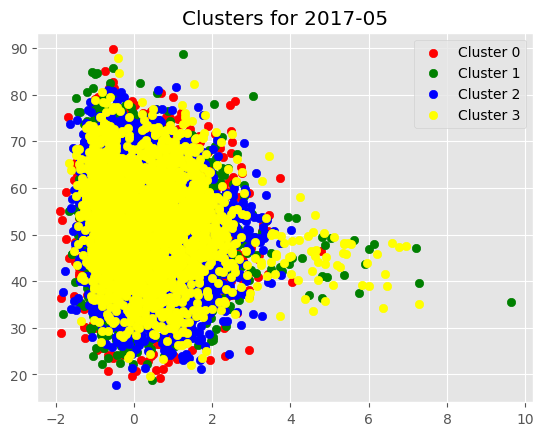

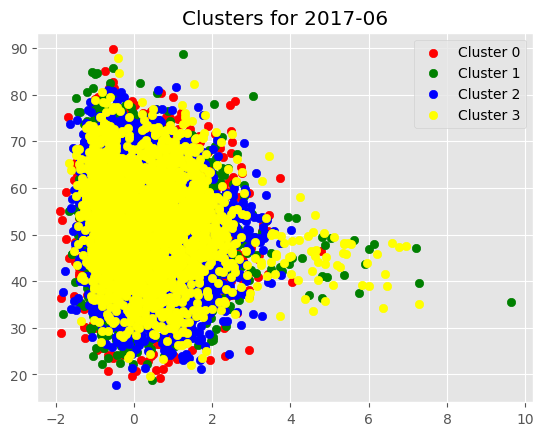

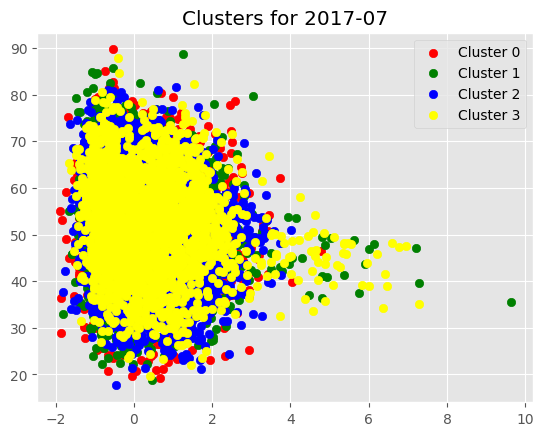

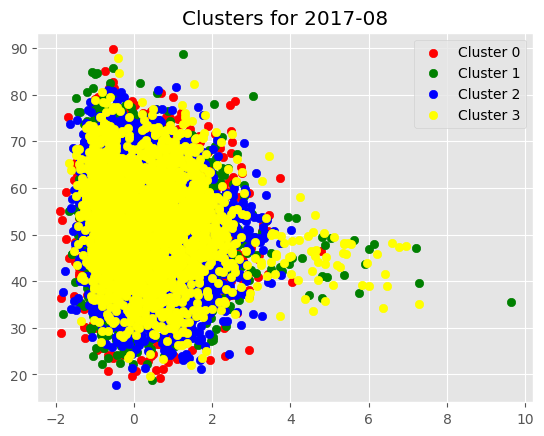

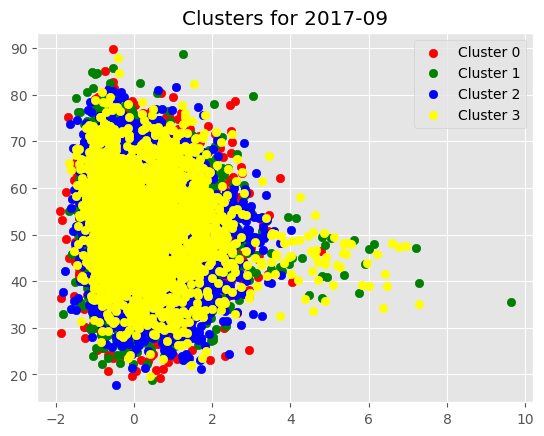

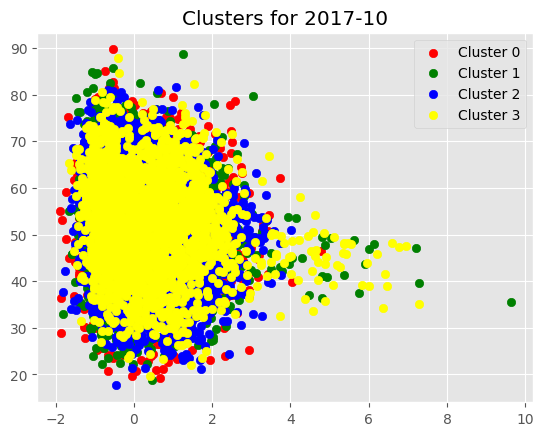

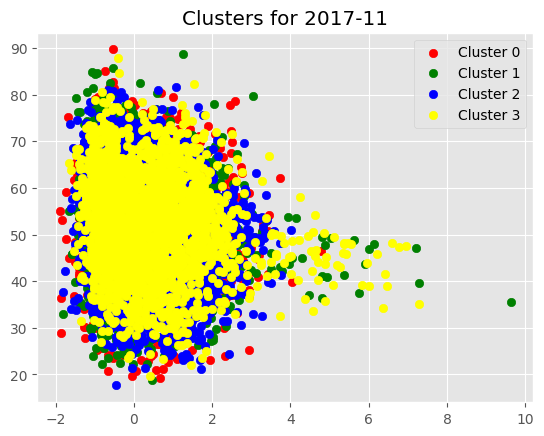

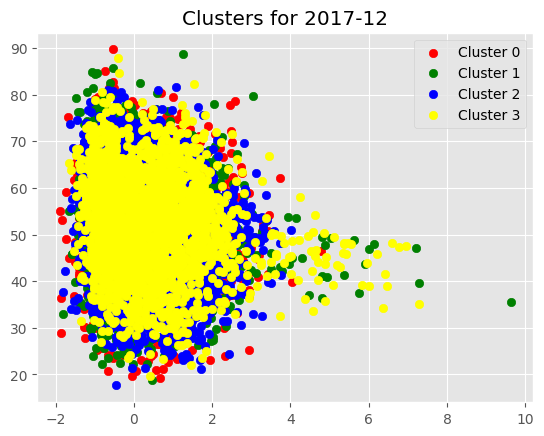

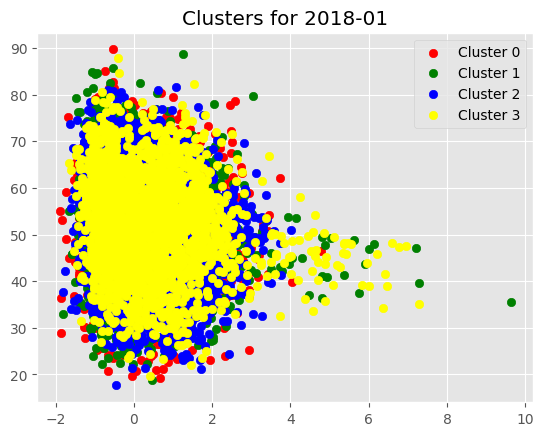

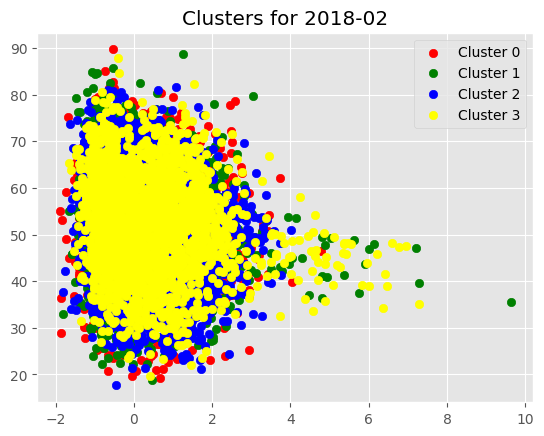

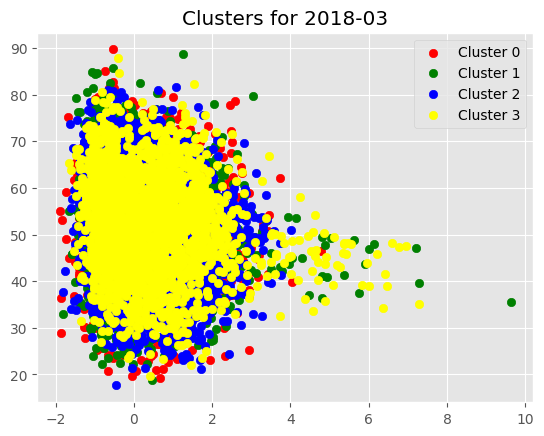

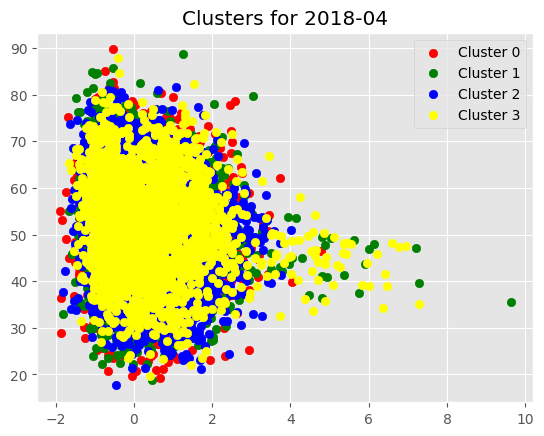

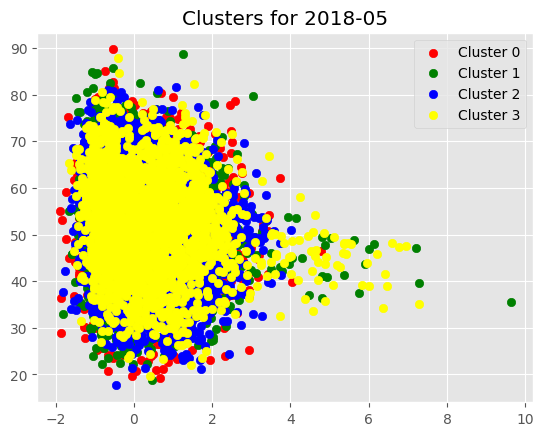

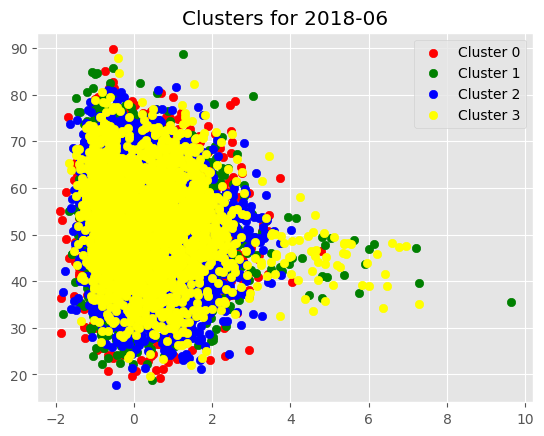

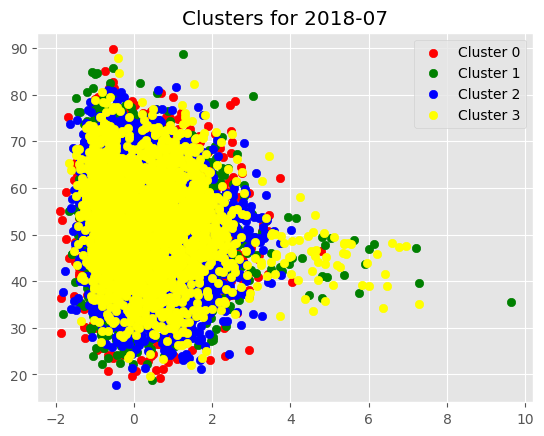

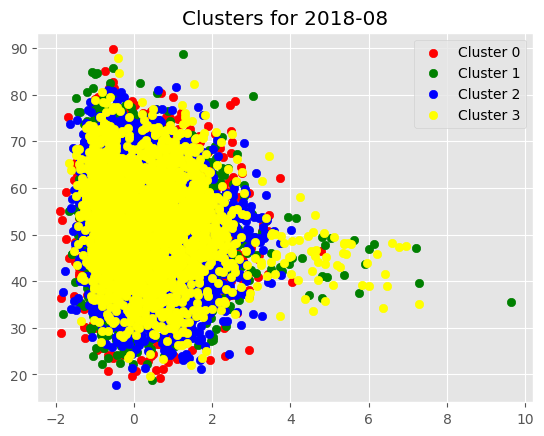

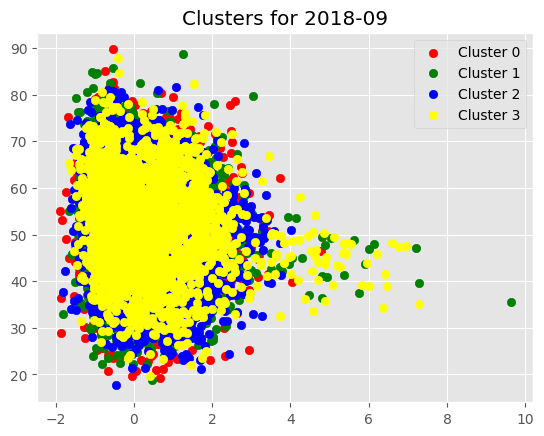

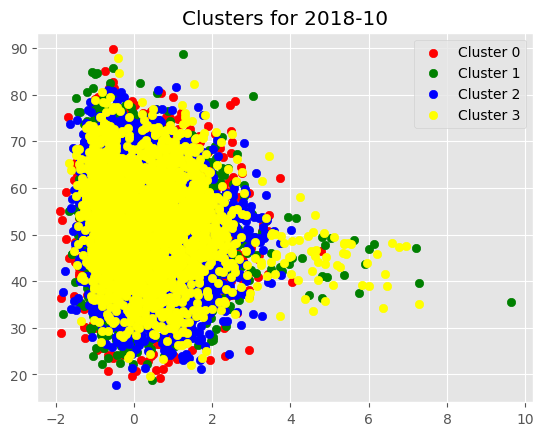

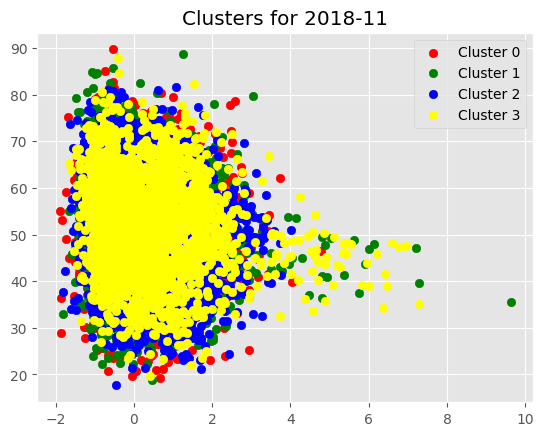

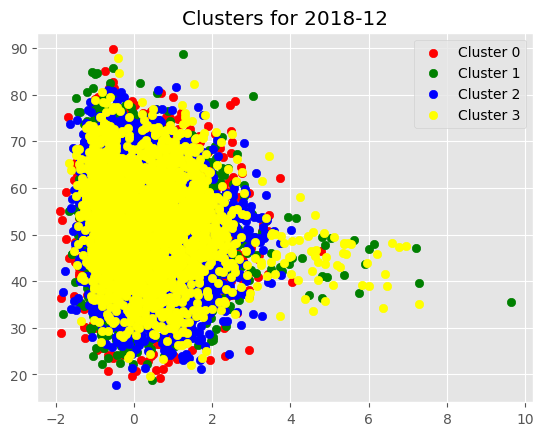

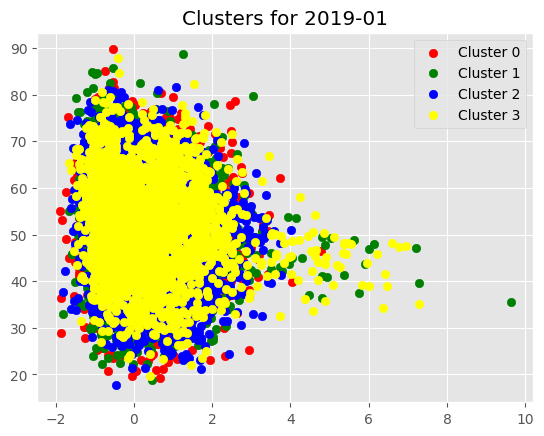

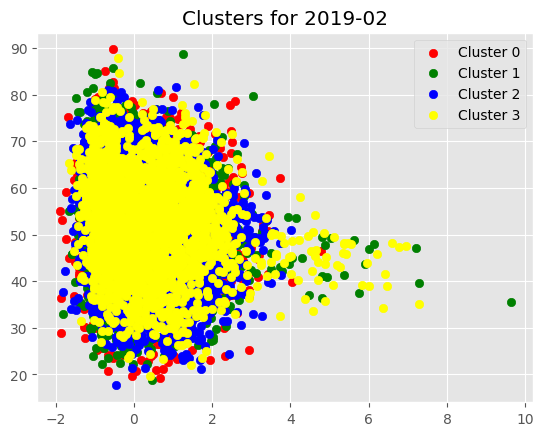

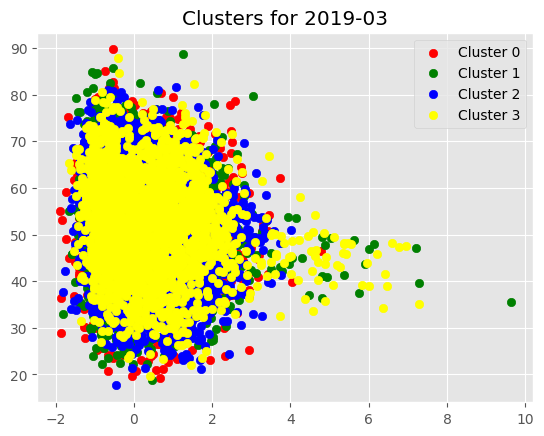

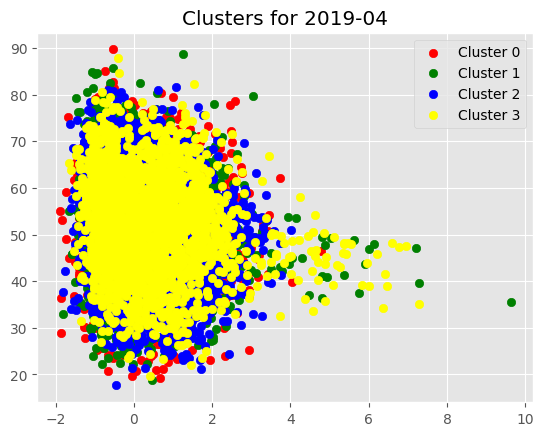

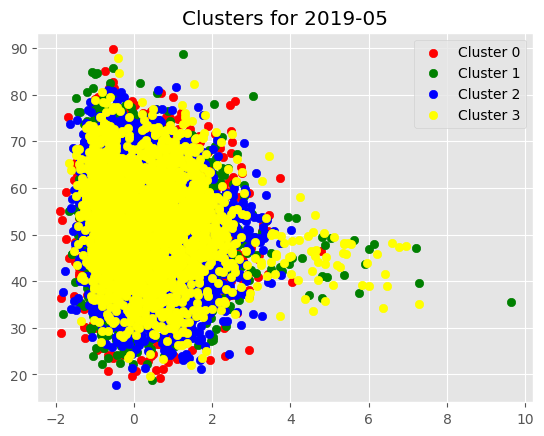

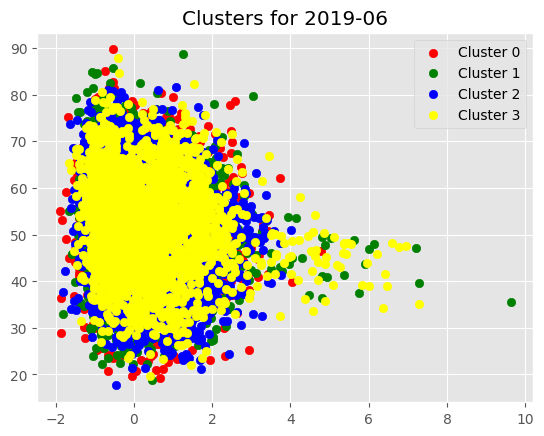

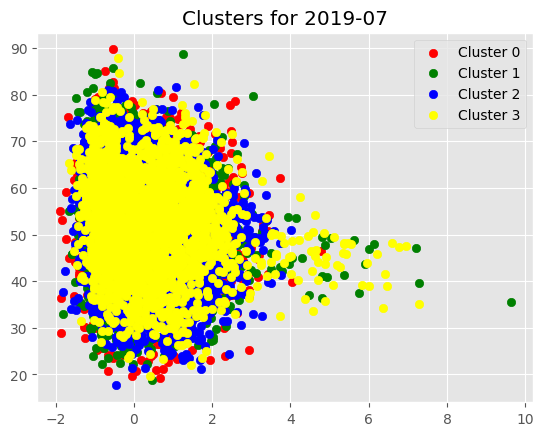

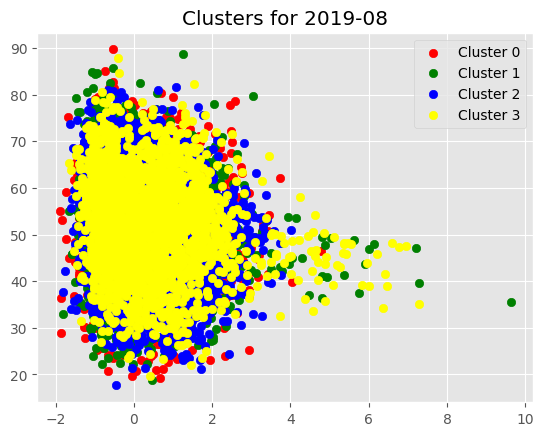

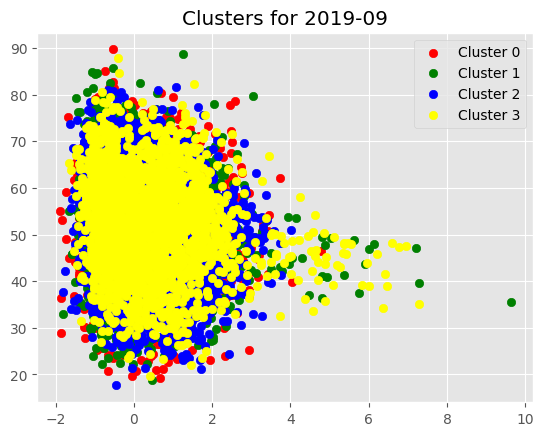

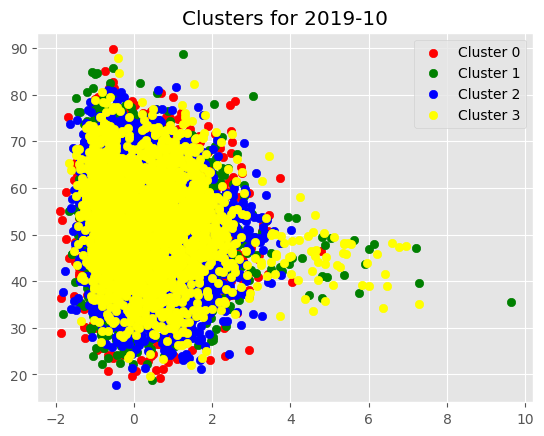

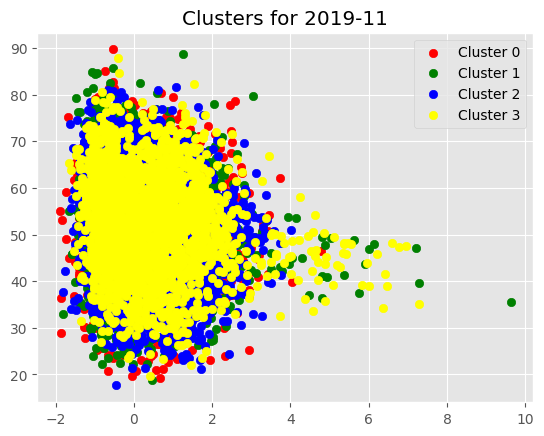

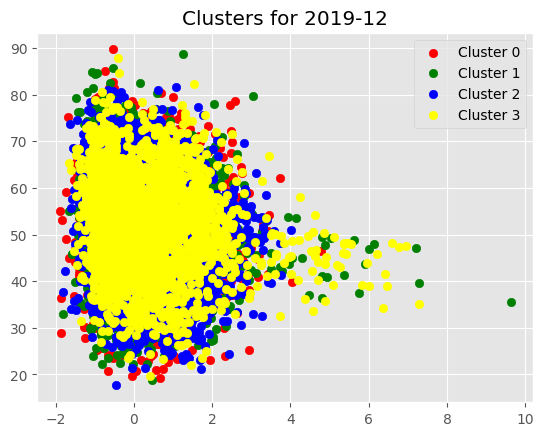

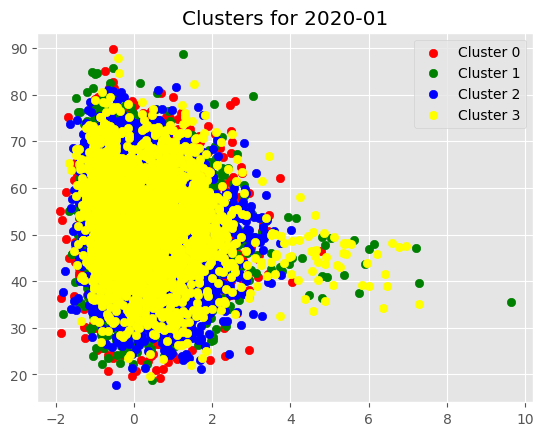

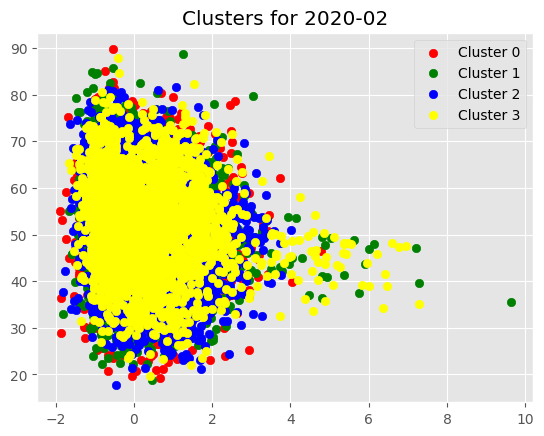

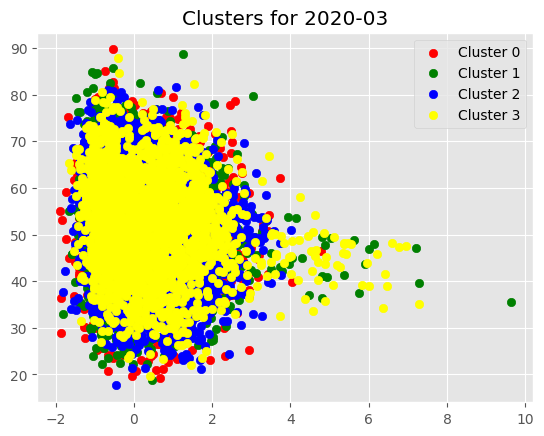

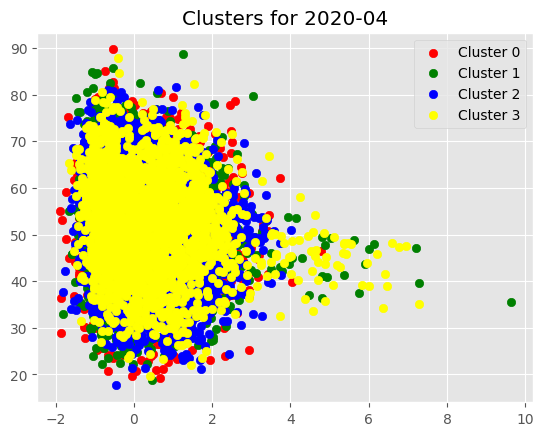

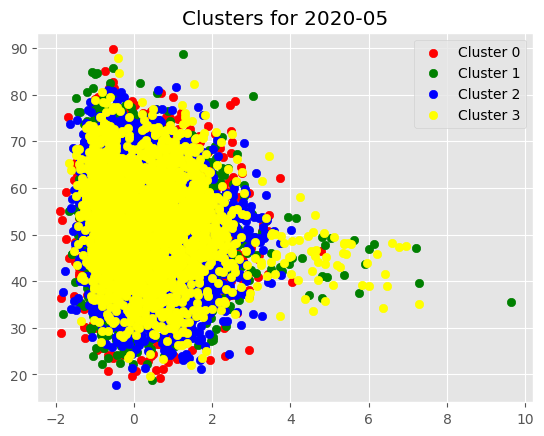

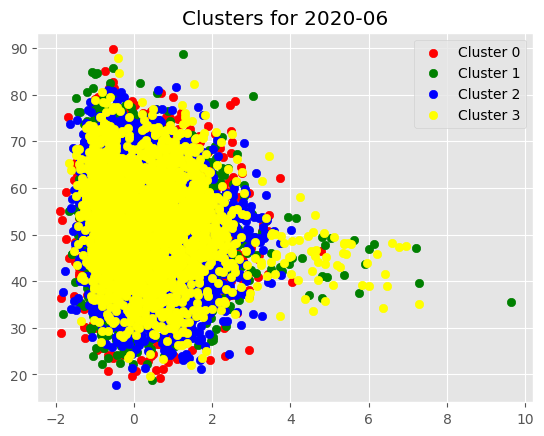

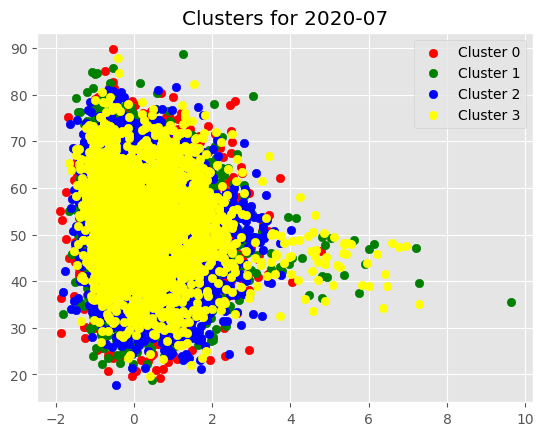

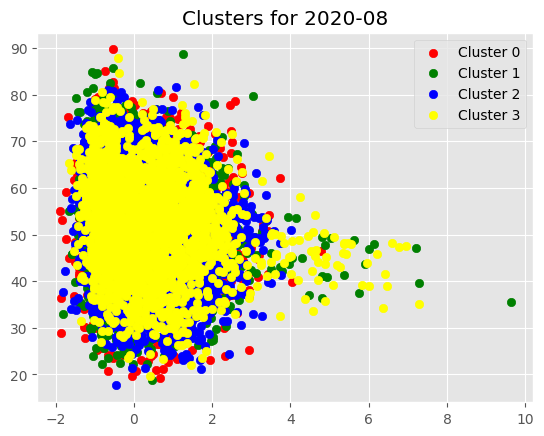

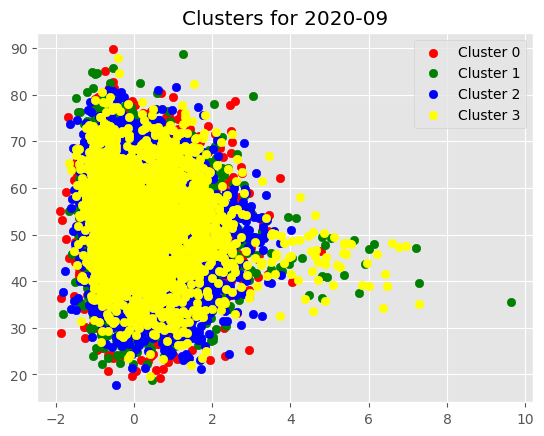

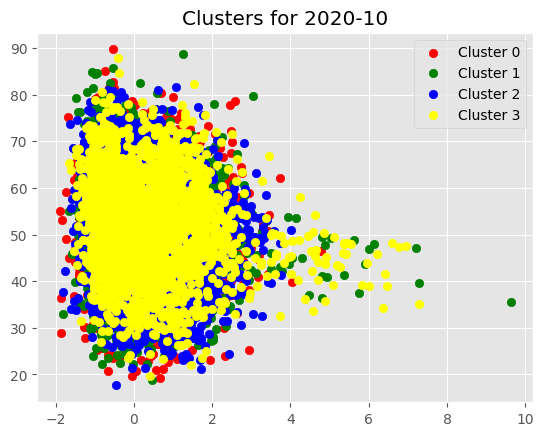

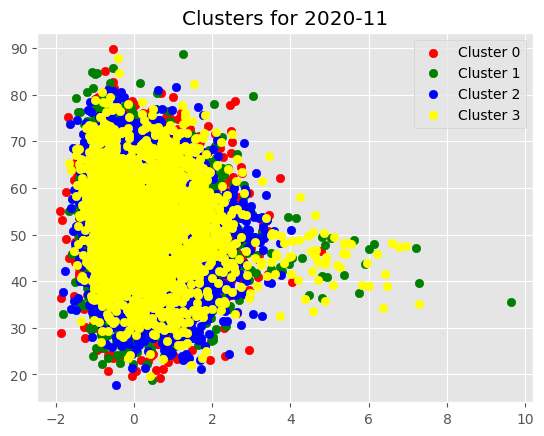

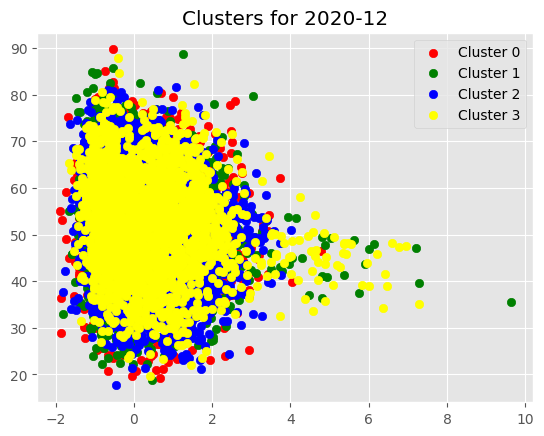

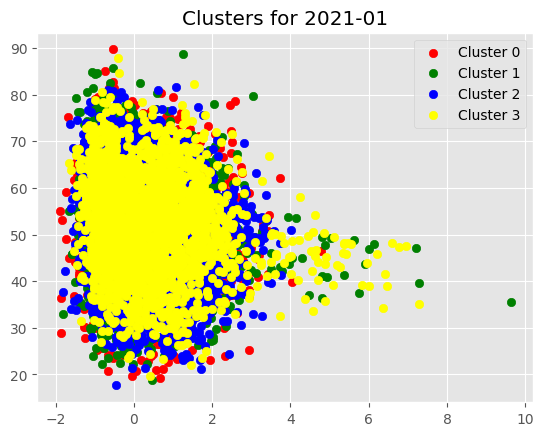

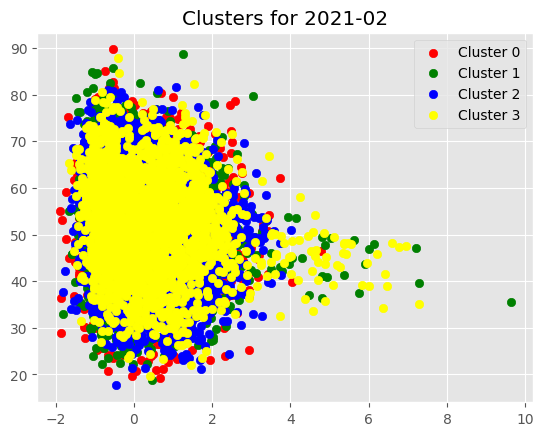

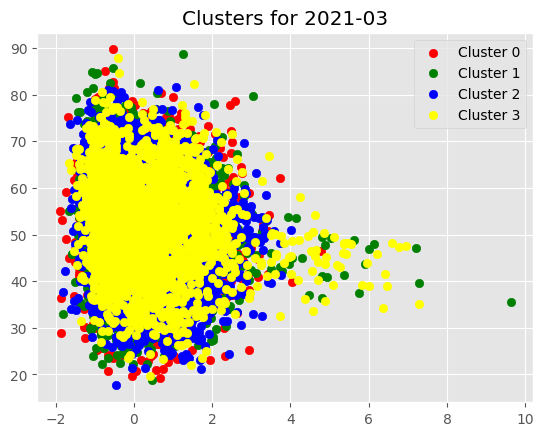

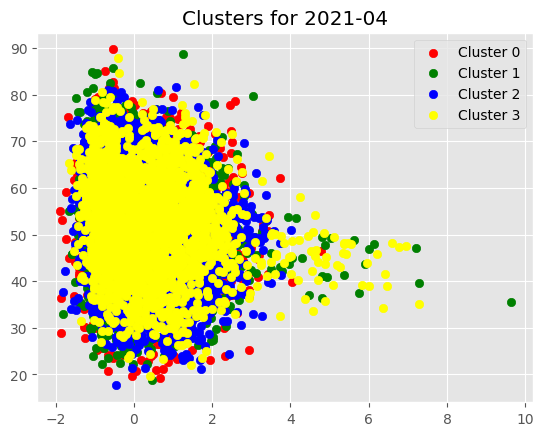

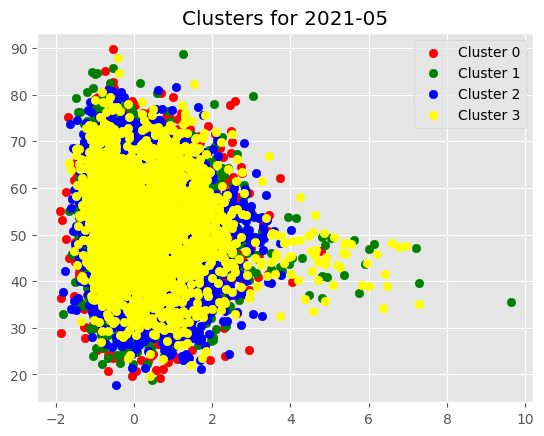

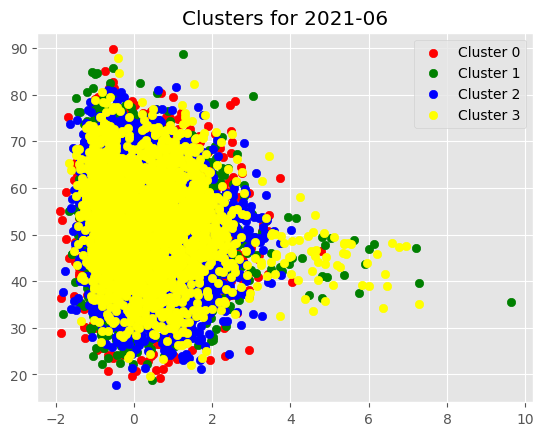

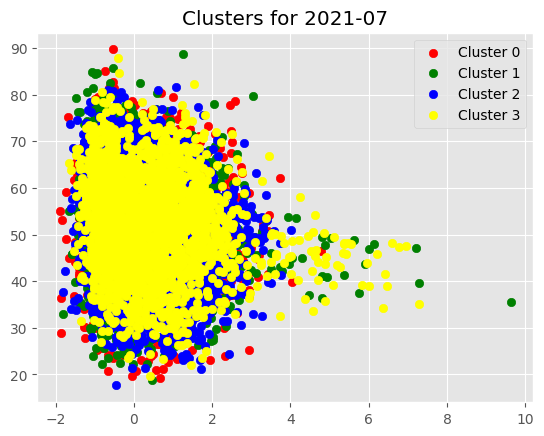

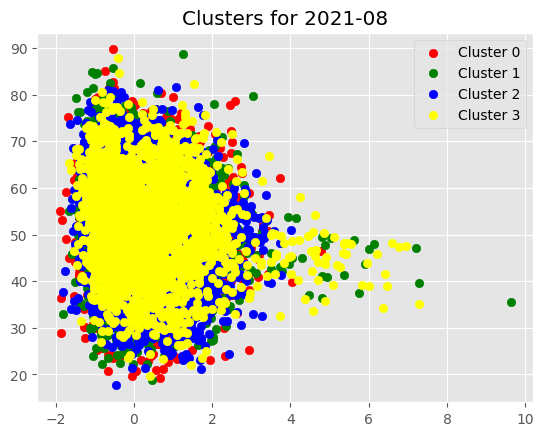

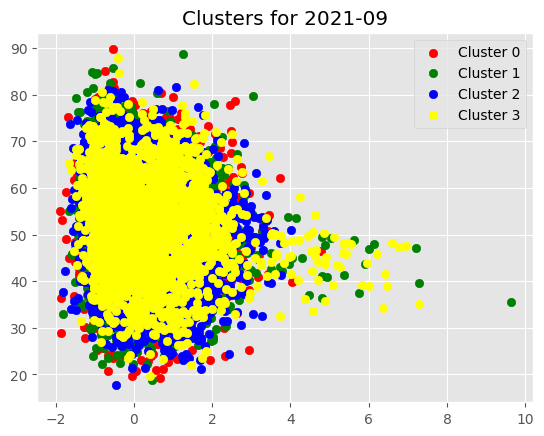

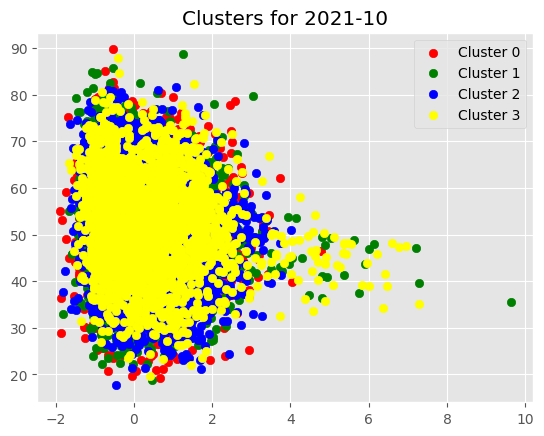

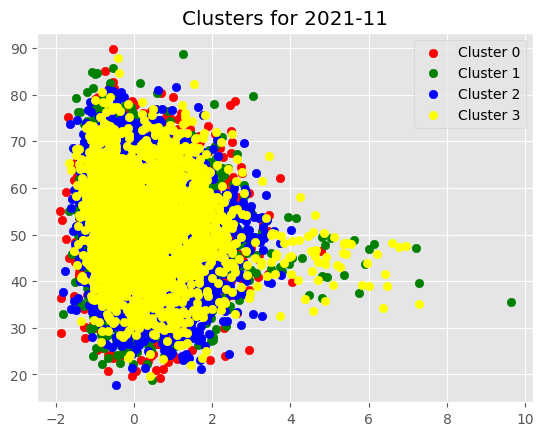

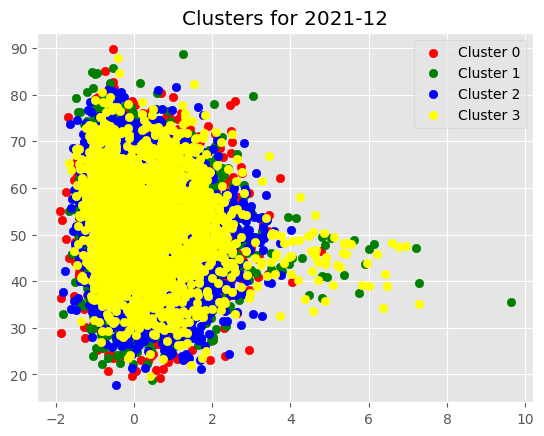

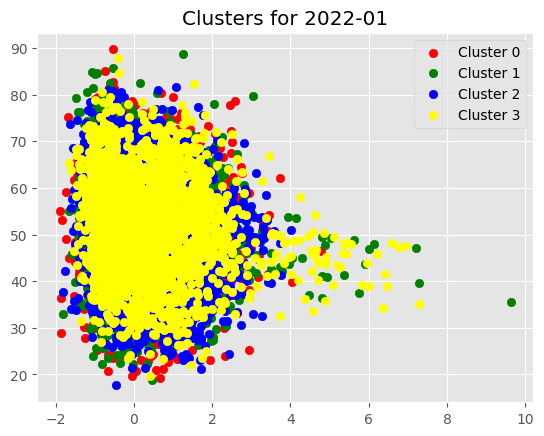

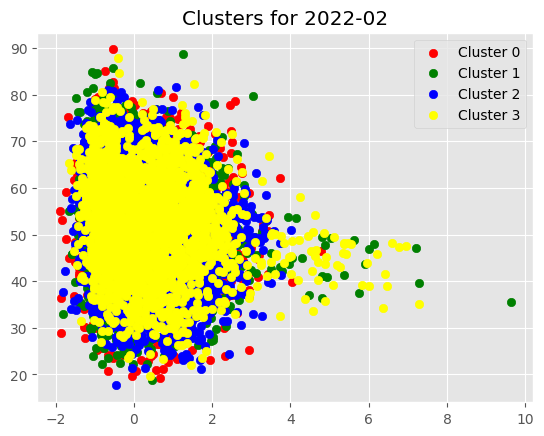

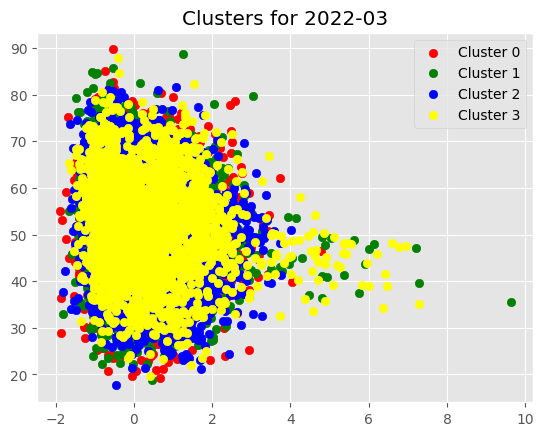

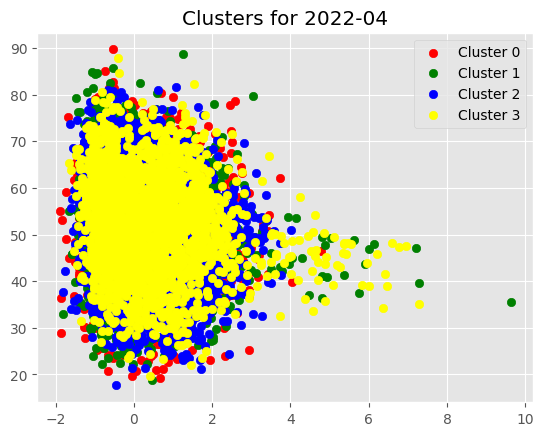

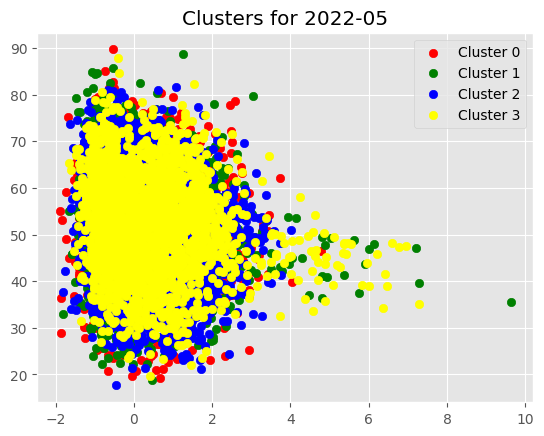

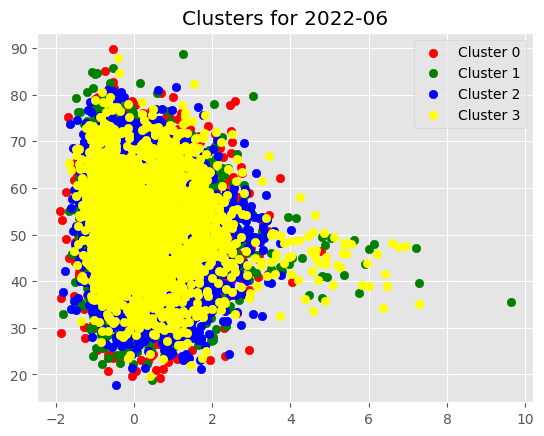

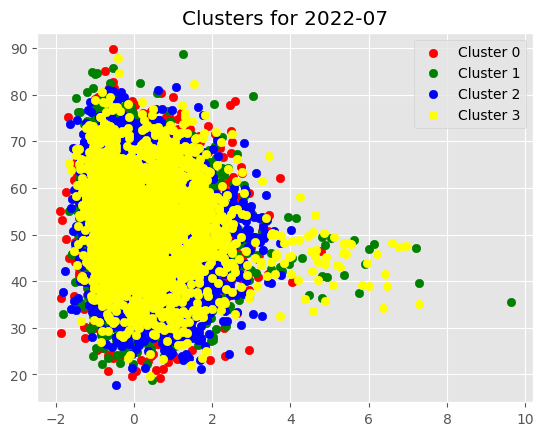

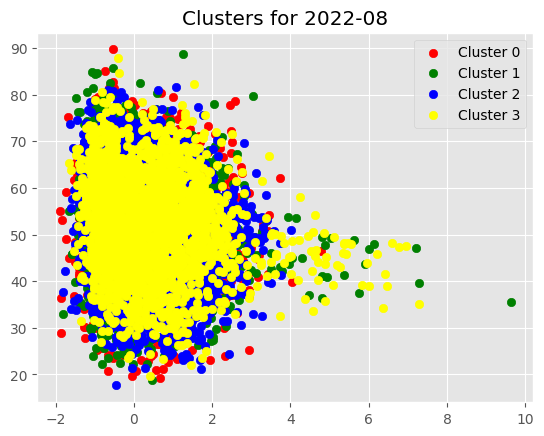

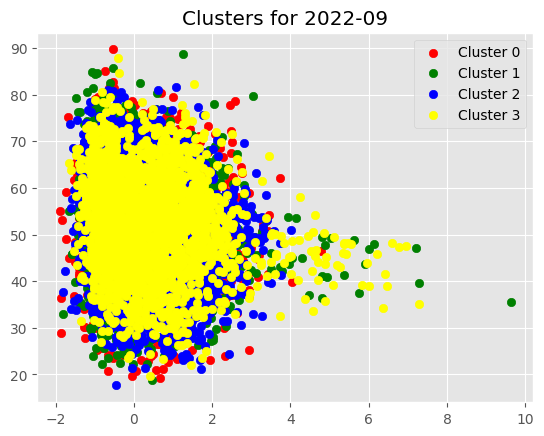

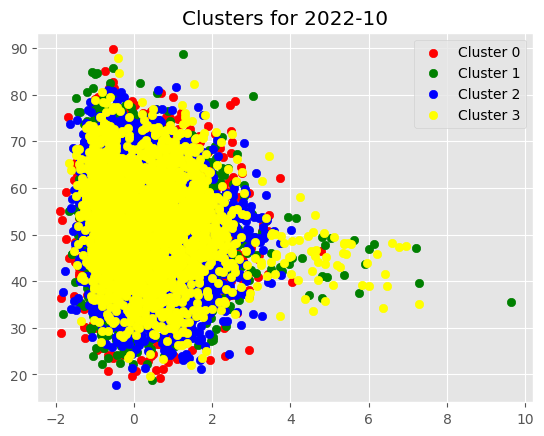

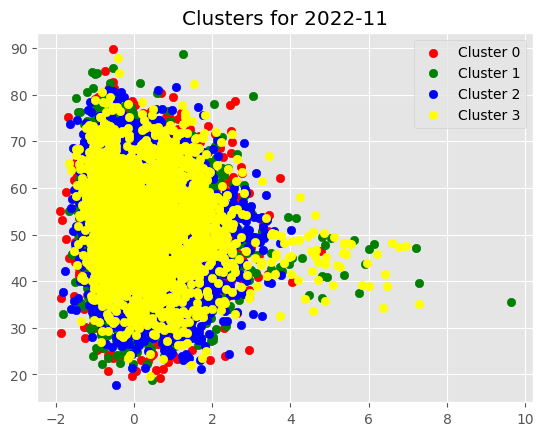

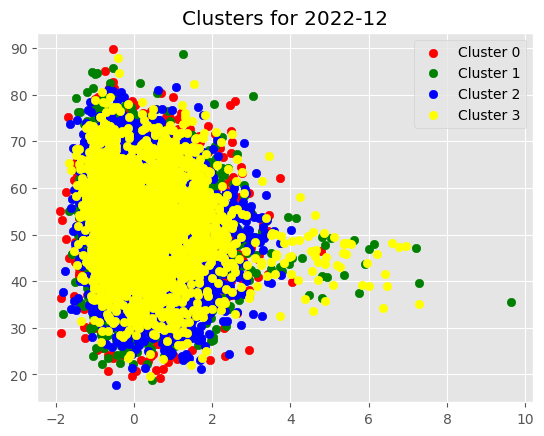

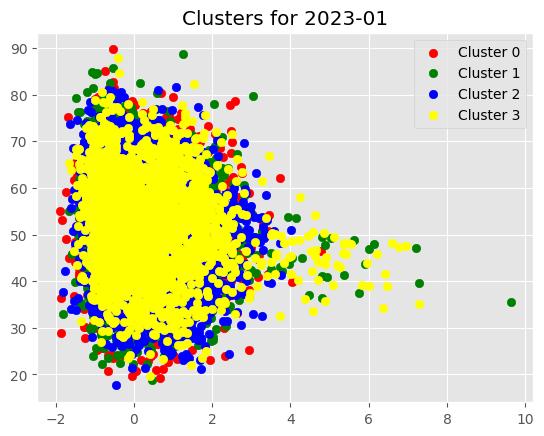

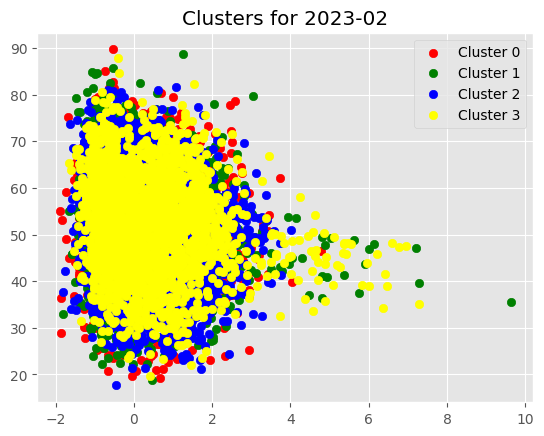

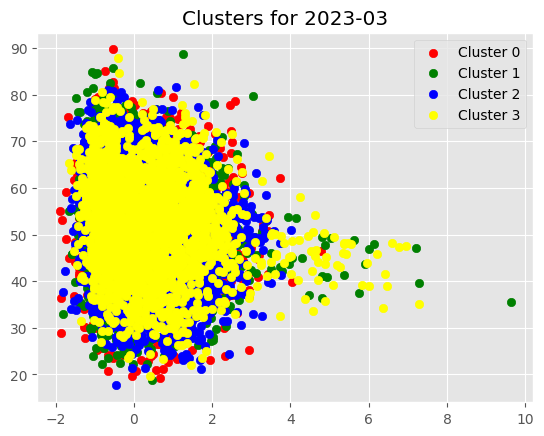

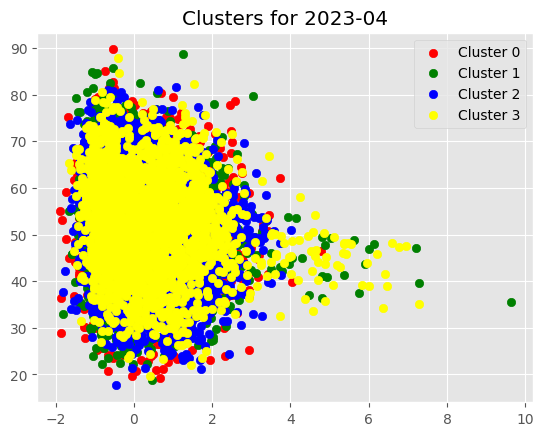

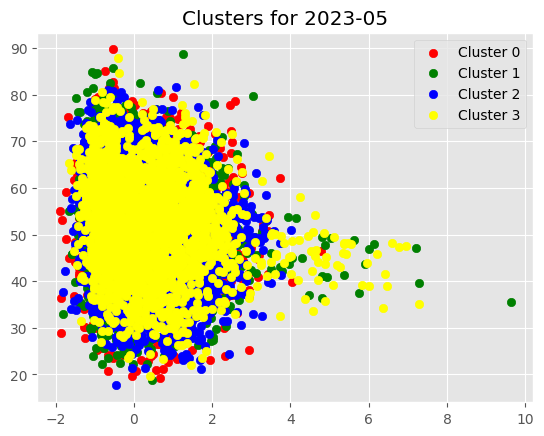

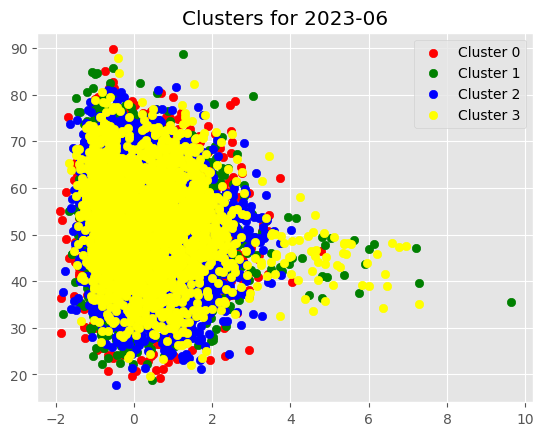

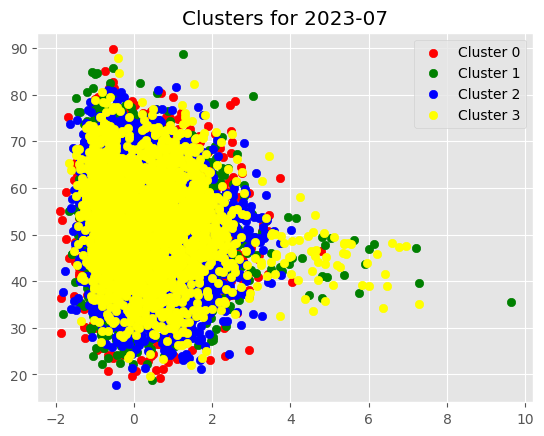

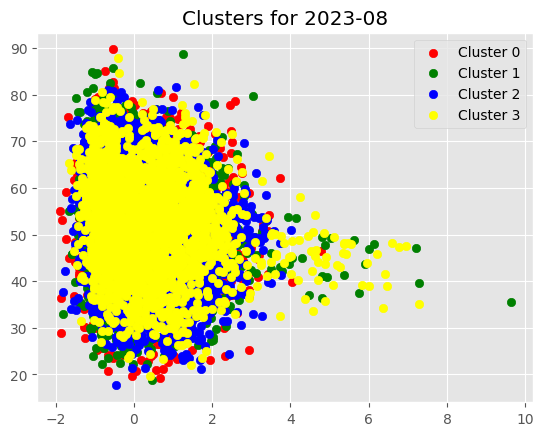

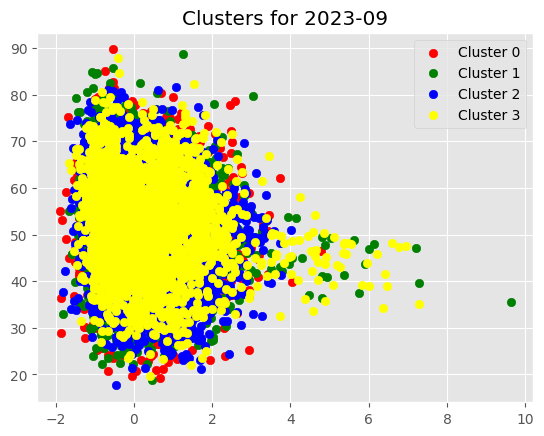

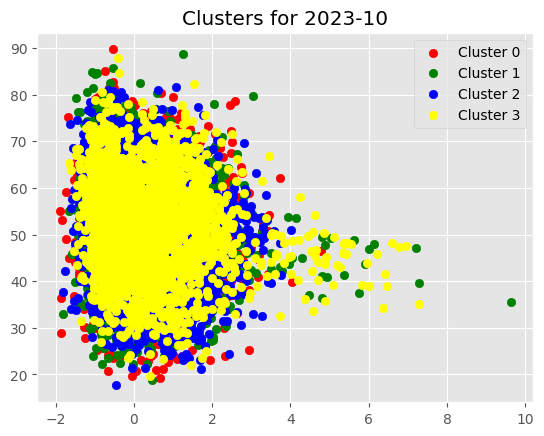

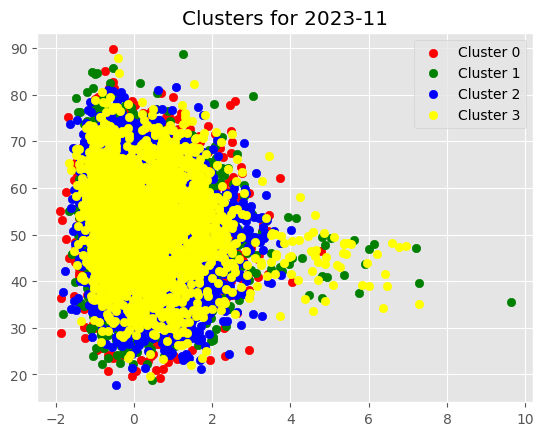

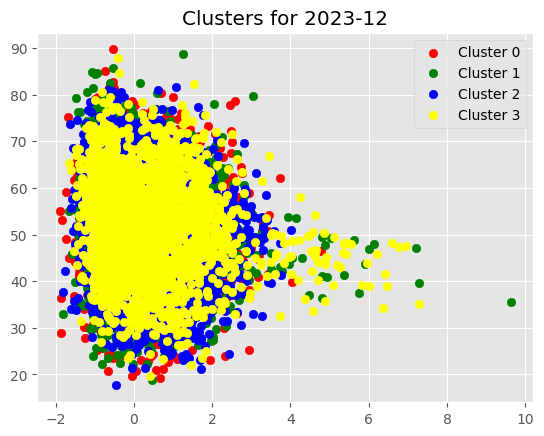

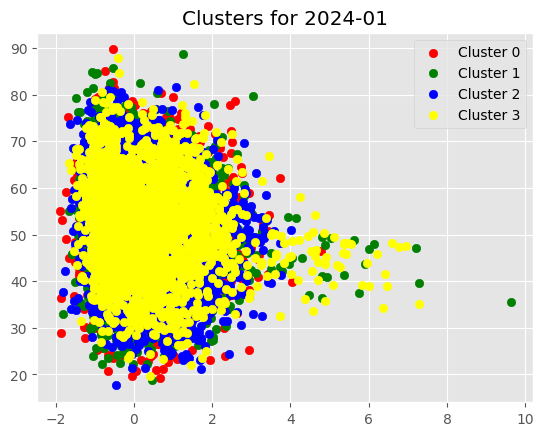

In [9]:
# Plot Clusters
def plot_clusters(df):
    # fig, ax = plt.subplots(figsize=(10, 6))
    # for i, cluster in df.groupby('Cluster'):
    #     cluster.plot.scatter(x='ATR', y='RSI', ax=ax label=f'Cluster {i}', color=f'C{i}')
    
    cluster0 = data[data['Cluster']==0]
    cluster1 = data[data['Cluster']==1]
    cluster2 = data[data['Cluster']==2]
    cluster3 = data[data['Cluster']==3]

    plt.scatter(cluster0['ATR'], cluster0['RSI'], color='red', label='Cluster 0')
    plt.scatter(cluster1['ATR'], cluster1['RSI'], color='green', label='Cluster 1')
    plt.scatter(cluster2['ATR'], cluster2['RSI'], color='blue', label='Cluster 2')
    plt.scatter(cluster3['ATR'], cluster3['RSI'], color='yellow', label='Cluster 3')
    
    plt.legend()
    plt.show()
    return 

plt.style.use('ggplot')
for i in data.index.get_level_values('Date').unique().tolist():
    g = data.xs(i, level=0)
    plt.title(f'Clusters for {i.strftime("%Y-%m")}')
    plot_clusters(g)



